In [26]:
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns 
import numpy as np

In [27]:
import yaml

In [28]:
import os 

os.chdir('E://bond-dex/bond-amm-simulation/')

In [29]:
from simulation.__NaiveTradeSimulator import NaiveTradeSimulator

In [30]:
from scripts.generate_stats_v1 import plot_stats

## Simulation for Yield

In [31]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
%autoreload 2

from simulation.__NaiveTradeSimulator import NaiveTradeSimulator

In [33]:
%%writefile config/yield_v1.yml

# time unit: minute

config:
  simulation:
    simulation_length: 525500
    begin_trade_time: 0
    maturity: 525600 #25754400 #525600
    initial_cash: 0.5
    initial_bond: 0.5256355481880121 #0.8243606353500641
#     bond_burning: 1

  fee:
    rate: 0.

  trader:
    trade_data: 'sources/input/actor_trade/simulated_eth_trade1.csv'

  pricing_config:
      pricing_method: 'yield-v1'
      params:
        
  tracking:
    dir: 'data/tracking/yield_v1'


Overwriting config/yield_v1.yml


In [34]:
with open('config/yield_v1.yml') as file:
    metadata = yaml.safe_load(file)

simulator = NaiveTradeSimulator(metadata['config'])
simulator.run()

Initialized simulation!

------------- Begin running simulation -------------


100%|████████████████████████████████████████████████████████████████████████| 525500/525500 [01:03<00:00, 8229.78it/s]


Total_burn: 0

Saving tracking data to data/tracking/yield_v1

------------------ Done simulation ------------------


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1000x800 with 0 Axes>

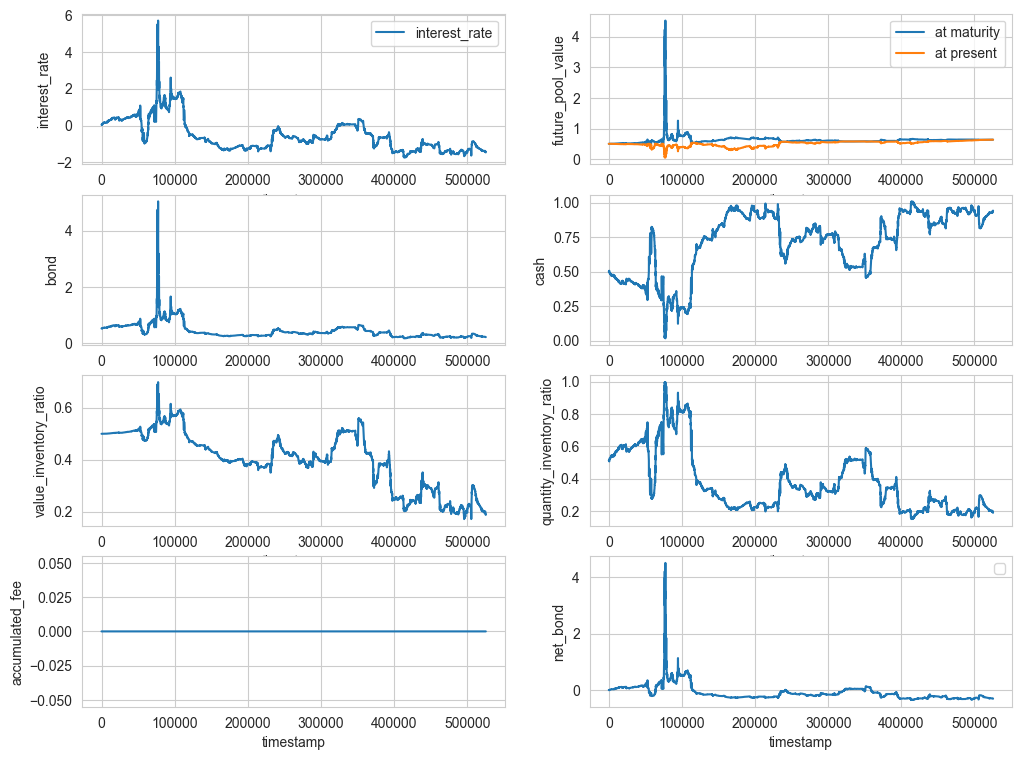

In [35]:
fig = plt.figure(figsize=(10, 8))

plot_stats('data/tracking/yield_v1', 'ALL_INFORMATION.json', fig_size=(12, 9))

## Simulation for Logit Notional

In [36]:
%%writefile config/logit_notional_v3.yml


version_name: 'v1'

config:
  simulation:
    simulation_length: 525500
    begin_trade_time: 0
    maturity: 5256000 #25754400 #525600
    initial_cash: 0.5
    initial_bond: 0.5
#     bond_burning: 1

  fee:
    rate: .000

  pricing_config:
      pricing_method: 'logit-notional-v3'
      params:
#         scalar: 50
#         anchor: 1.05
        kappa: 0.02
        r_star: 0.05

  trader:
    trade_data: 'sources/input/actor_trade/simulated_eth_trade1.csv'

  tracking:
    dir: 'data/tracking/notional-v3'

Overwriting config/logit_notional_v3.yml


In [37]:
%autoreload 2

from simulation.__NaiveTradeSimulator import NaiveTradeSimulator

In [38]:
with open('config/logit_notional_v3.yml') as file:
    metadata = yaml.safe_load(file)

simulator = NaiveTradeSimulator(metadata['config'])
simulator.run()

Initialized simulation!

------------- Begin running simulation -------------


100%|████████████████████████████████████████████████████████████████████████| 525500/525500 [01:04<00:00, 8120.29it/s]


Total_burn: 0

Saving tracking data to data/tracking/notional-v3

------------------ Done simulation ------------------


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1000x800 with 0 Axes>

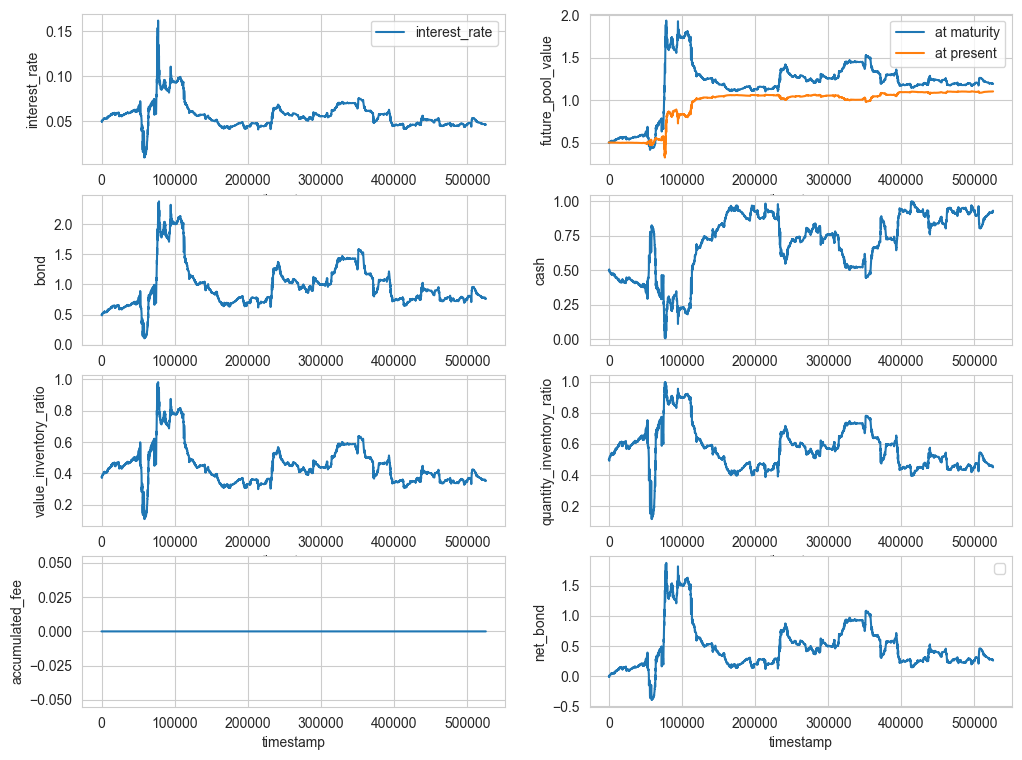

In [39]:
fig = plt.figure(figsize=(10, 8))

plot_stats('data/tracking/notional-v3/', 'ALL_INFORMATION.json', fig_size=(12, 9))

## Proposed logit

$p = \frac{X_0}{X_0 + y_0}$

$r = \kappa logit(p) + r^{\star}$

$C_1 = y_0[e^{\kappa^{-1}(r_0 - r^\star)} + 1]^{\tau\kappa + 1}$

$\alpha = \frac{1}{1 + \tau\kappa}$ 

$K = e^{-\tau r^{\star} \alpha}$

$C_2 = C_1^{\alpha}$

$Kx^\alpha + y^\alpha = C_2$  

At time t, suppose the state of pool is $(x_0, y_0, r_0)$, and there is a trade dy to the pool. 

-> $Kx_{0}^{\alpha} + y_0^{\alpha} = C_2$ 

-> $r_{0} = r^{\star} - \kappa \bigr[ln(K) + \alpha ln(\frac{x_0}{y_0})\bigr]$

-> $K(x + dx)^{\alpha} + (y+dy)^{\alpha} = K x_0^{\alpha} + y_0^{\alpha}$

In [40]:
_user_defined_func_path = "scripts/price_functions/price_v1.py"

In [41]:
%%writefile {_user_defined_func_path}

import numpy as np
from scipy.special import logit


def calculate_price(x, y, dx, dy, time_to_maturity, maturity_length, r_star, kappa) -> float:
    tau = time_to_maturity

    alpha = 1 / (1 + tau * kappa)
    Br = np.exp(-r_star * tau) 
    
    C = (x * Br) ** alpha + y ** alpha

    if dx != 0:
        new_x = x + dx
        new_y = (C - (Br * new_x) ** alpha) ** (1 / alpha)
        dy = new_y - y
    elif dy != 0:
        new_y = y + dy
        new_x = (C - new_y ** alpha) ** (1 / alpha) / Br
        dx = new_x - x

    if abs((x * Br) ** alpha + y ** alpha - ((x + dx) * Br) ** alpha - (y + dy) ** alpha) > 0.00001:
        raise Exception('Something wrong with ODE!')
    
    r0 = r_star * alpha + kappa * alpha * np.log(x / y)
    if abs(logit(x * np.exp(-r0 * tau) / (x * np.exp(-r0 * tau) + y)) * kappa + r_star - r0) > 0.00001:
        raise Exception('R0 not match!')

    if dx == 0 and dy == 0:
        dy = -np.exp(-tau * r0)
        dx = 1

    price = abs(dy / dx)

    return price

Overwriting scripts/price_functions/price_v1.py


In [42]:
%%writefile config/user_defined_v1.yml


version_name: 'v1'

config:
  simulation:
    simulation_length: 525500
    begin_trade_time: 0
    maturity: 5256000 #25754400 #525600
    initial_cash: 0.5
    initial_bond: 0.8243606353500641
    bond_burning: 1

  fee:
    rate: .000

  pricing_config:
      pricing_method: 'user-defined'
      params:
        price_function: 'scripts/price_functions/price_v1.py'
        kappa: 0.02
        r_star: 0.05

  trader:
    trade_data: 'sources/input/actor_trade/simulated_eth_trade1.csv'

  tracking:
    dir: 'data/tracking/v1.1'

Overwriting config/user_defined_v1.yml


In [43]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
%autoreload 2

from simulation.__NaiveTradeSimulator import NaiveTradeSimulator

In [45]:
with open('config/user_defined_v1.yml') as file:
    metadata = yaml.safe_load(file)

simulator = NaiveTradeSimulator(metadata['config'])
simulator.run()

Initialized simulation!

------------- Begin running simulation -------------


100%|████████████████████████████████████████████████████████████████████████| 525500/525500 [01:48<00:00, 4824.60it/s]


Total_burn: -0.023333729574875207

Saving tracking data to data/tracking/v1.1

------------------ Done simulation ------------------


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1000x800 with 0 Axes>

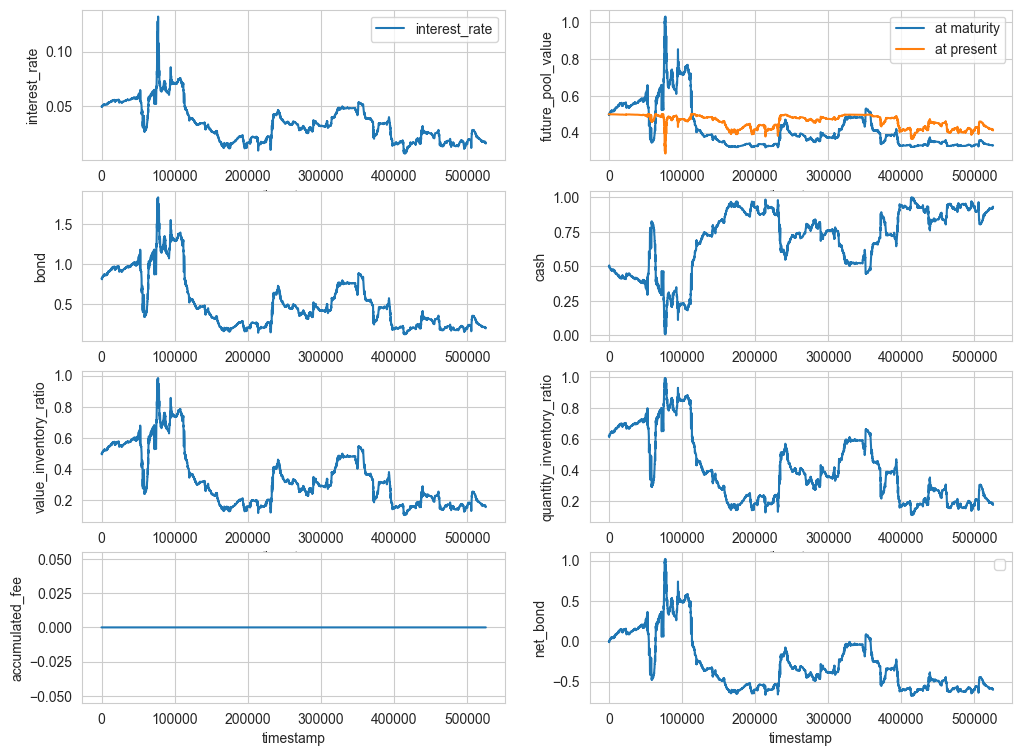

In [46]:
fig = plt.figure(figsize=(10, 8))

plot_stats('data/tracking/v1.1', 'ALL_INFORMATION.json', fig_size=(12, 9))